In [9]:
import cv2
import numpy as np
import pandas as pd
from random import shuffle
from tqdm import tqdm
import os
from glob import glob
import tflearn
import tensorflow as tf
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

### Print Directory Tree

In [10]:
import os
startpath = "F:\\Downloads\\train\\"
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        i = 0
        for f in files:
            i += 1
            print('{}{}'.format(subindent, f))
            if i >=3:
                break

list_files(startpath)

/
    checkpoint
    dogsvscats-0.001-3conv-basic.model.data-00000-of-00001
    dogsvscats-0.001-3conv-basic.model.index
.ipynb_checkpoints/
    KERAS_DOG_CAT-checkpoint.ipynb
    TFLearn_DOG_CAT-checkpoint.ipynb
    TFLearn_MNIST_CNN-checkpoint.ipynb
data/
    train/
        cats/
            cat.0.jpg
            cat.1.jpg
            cat.10.jpg
        dogs/
            dog.0.jpg
            dog.1.jpg
            dog.10.jpg
    validation/
        cats/
            cat.1000.jpg
            cat.1001.jpg
            cat.1002.jpg
        dogs/
            dog.1001.jpg
            dog.1002.jpg
            dog.1003.jpg
log/
    dogsvscats-0.001-2conv-basic.model/
        events.out.tfevents.1527678264.NODE522
        events.out.tfevents.1527678753.NODE522
        events.out.tfevents.1527678935.NODE522
    dogsvscats-0.001-3conv-basic.model/
        events.out.tfevents.1527682257.NODE522
    dogsvscats-0.001-3conv-color150.model/
        events.out.tfevents.1527683504.NODE522
        even

### Set Constants

In [11]:
TRAIN_DIR = 'F:\\Downloads\\train\\data\\train'
VAL_DIR = 'F:\\Downloads\\train\\data\\validation'
IMG_SIZE = 150
LR = 1e-3
N_CHANNEL = 3
MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '3conv-color150')

In [12]:
print("# of Images in Train Dir: ",len(glob(TRAIN_DIR+"\\*\\*.*",recursive=True)))
print("# of Images in Validation Dir: ",len(glob(VAL_DIR+"\\*\\*.*",recursive=True)))

# of Images in Train Dir:  2001
# of Images in Validation Dir:  800


### Create Train/Test Datasets

In [13]:
def label_img(img):
    label = img.split(".")[0]
    if label == 'cat':
        return [1,0]
    if label == 'dog':
        return [0,1]

def create_data(DIR,save_npy_name,N_CHANNEL):
    data = []
    images = glob(DIR+"\\*\\*.*",recursive=True)
    for img in tqdm(images):
        label = label_img(img.split("\\")[-1].split(".")[0])
        if N_CHANNEL == 3:
            img = cv2.imread(img)
        else:
            img = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        data.append([np.array(img),np.array(label)])
    shuffle(data)
    np.save(save_npy_name,data)
    return data

Needs to be done only once

In [22]:
if os.path.exists("train_data.npy"):
    train_data = np.load("train_data.npy")
else:
    train_data = create_data(TRAIN_DIR,"train_data.npy",N_CHANNEL)
    
if os.path.exists("test_data.npy"):
    test_data=np.load("test_data.npy")
else:
    test_data = create_data(VAL_DIR,"test_data.npy",N_CHANNEL)

### Define CNN Model using TFLearn

In [25]:
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, N_CHANNEL], name='input',dtype=tf.float32) # change channel size 
# 1st Iteration Start
convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = max_pool_2d(convnet, 2)
# 1st Iteration End # loss: 11.78922 - acc: 0.4880

# 2nd Iteration Start 
convnet = conv_2d(convnet, 64, 3, activation='relu')  # 3rd iter 32 to 128 
convnet = max_pool_2d(convnet, 2)

# 3rd Iteration
# convnet = conv_2d(convnet, 64, 3, activation='relu')
# convnet = max_pool_2d(convnet, 2)

# convnet = conv_2d(convnet, 32, 3, activation='relu')
# convnet = max_pool_2d(convnet, 2)
# 2nd Iteration End # loss: 0.69117 - acc: 0.5078

convnet = fully_connected(convnet, 64, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='sigmoid')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [23]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')
    
X = np.array([i[0] for i in train_data]).reshape(-1,IMG_SIZE,IMG_SIZE,N_CHANNEL) # change channel size 
Y = [i[1] for i in train_data]

test_x = np.array([i[0] for i in test_data]).reshape(-1,IMG_SIZE,IMG_SIZE,N_CHANNEL)# change channel size 
test_y = [i[1] for i in test_data]

X = X/255.  #not when GreyScale
test_x = test_x/255.

In [26]:
model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
            snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 319  | total loss: 0.31978 | time: 88.238s
| Adam | epoch: 010 | loss: 0.31978 - acc: 0.8609 -- iter: 1984/2001
Training Step: 320  | total loss: 0.32559 | time: 104.919s
| Adam | epoch: 010 | loss: 0.32559 - acc: 0.8545 | val_loss: 0.64520 - val_acc: 0.7087 -- iter: 2001/2001
--


In [ ]:
#!pip install tensorboard
#!tensorboard --logdir=foo:F:\Downloads\train\log

In [27]:
model.save(MODEL_NAME)

INFO:tensorflow:F:\Downloads\train\dogsvscats-0.001-3conv-color150.model is not in all_model_checkpoint_paths. Manually adding it.


### Test the model

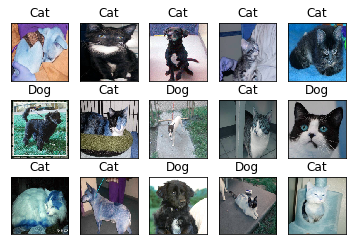

In [28]:
import matplotlib.pyplot as plt

test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:15]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,5,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,3)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()